# Лабораторная работа №4

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, precision_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer, MissingIndicator
%matplotlib inline 
sns.set(style="ticks")

target_col="points"

In [2]:
data = pd.read_csv("winemag-data_first150k.csv")
for col in data.columns:
    pct_missing = np.mean(data[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

Unnamed: 0 - 0%
country - 0%
description - 0%
designation - 30%
points - 0%
price - 9%
province - 0%
region_1 - 17%
region_2 - 60%
variety - 0%
winery - 0%


## Обработка пропусков

In [3]:
data.drop(columns=['region_2'], inplace=True) 

In [4]:
data.price.fillna(data.price.median(), inplace = True)

In [5]:
data.drop(columns=['Unnamed: 0'], inplace=True) 

In [6]:
cat_cols = []
total_count = data.shape[0]
for col in data.columns:
    # Количество пустых значений 
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='object'):
        cat_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка country. Тип данных object. Количество пустых значений 5, 0.0%.
Колонка designation. Тип данных object. Количество пустых значений 45735, 30.3%.
Колонка province. Тип данных object. Количество пустых значений 5, 0.0%.
Колонка region_1. Тип данных object. Количество пустых значений 25060, 16.6%.


In [7]:
cat_temp_data = data[['designation']]
cat_temp_data.head()

,designation
0,Martha's Vineyard
1,Carodorum Selección Especial Reserva
2,Special Selected Late Harvest
3,Reserve
4,La Brûlade


In [8]:
# Импьютация наиболее частыми значениями
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data_imp = imp.fit_transform(cat_temp_data)
data_imp
np.unique(data_imp)

array(['"M"', '#50 Mon Chou', '#SocialSecret', ..., 'ía Crianza',
       'Župska', "‘Rough Justice' Red"], dtype=object)

In [9]:
cat_temp_data1 = data[['region_1']]
cat_temp_data1.head()

,region_1
0,Napa Valley
1,Toro
2,Knights Valley
3,Willamette Valley
4,Bandol


In [10]:
# Импьютация наиболее частыми значениями
imp1 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data_imp1 = imp1.fit_transform(cat_temp_data1)
data_imp1
np.unique(data_imp1)

array(['Abruzzo', 'Adelaida District', 'Adelaide', ...,
       'Yorkville Highlands', 'Yountville', 'Zonda Valley'], dtype=object)

In [11]:
data.designation = data_imp
data.region_1 = data_imp1

In [12]:
for col in data.columns:
    pct_missing = np.mean(data[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

country - 0%
description - 0%
designation - 0%
points - 0%
price - 0%
province - 0%
region_1 - 0%
variety - 0%
winery - 0%


In [13]:
data = data.dropna(axis=0, how='any')
data.head()

,country,description,designation,points,price,province,region_1,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,Provence red blend,Domaine de la Bégude


In [14]:
for col in data.columns:
    null_count = data[data[col].isnull()].shape[0]
    if null_count == 0:
        column_type = data[col].dtype
        print('{} - {} - {}'.format(col, column_type, null_count))

country - object - 0
description - object - 0
designation - object - 0
points - int64 - 0
price - float64 - 0
province - object - 0
region_1 - object - 0
variety - object - 0
winery - object - 0


## Кодирование категориальных признаков

In [15]:
le = LabelEncoder()
for col in data.columns:
    column_type = data[col].dtype
    if column_type == 'object':
        data[col] = le.fit_transform(data[col]);
        print(col)

country
description
designation
province
region_1
variety
winery


In [16]:
data.head()

,country,description,designation,points,price,province,region_1,variety,winery
0,44,88311,17271,96,235.0,51,738,70,7286
1,40,56022,4398,96,110.0,274,1070,553,1231
2,44,44593,25380,96,90.0,51,528,468,9032
3,44,87818,22306,96,65.0,282,1222,402,11001
4,15,84626,14260,95,66.0,313,66,422,5409


## Разделение выборки на обучающую и тестовую

In [17]:
X = data.drop(target_col, axis=1)
Y = data[target_col]

In [18]:
X

,country,description,designation,price,province,region_1,variety,winery
0,44,88311,17271,235.0,51,738,70,7286
1,40,56022,4398,110.0,274,1070,553,1231
2,44,44593,25380,90.0,51,528,468,9032
3,44,87818,22306,65.0,282,1222,402,11001
4,15,84626,14260,66.0,313,66,422,5409
...,...,...,...,...,...,...,...,...
150925,22,46137,22306,20.0,359,434,616,6281
150926,15,49511,7256,27.0,72,197,106,7137
150927,22,76209,26590,20.0,359,434,616,13184
150928,15,8705,11568,52.0,72,197,106,6934


In [19]:
Y

0         96
1         96
2         96
3         96
4         95
          ..
150925    91
150926    91
150927    91
150928    90
150929    90
Name: points, Length: 150925, dtype: int64

In [20]:
pd.DataFrame(X, columns=X.columns).describe()

,country,description,designation,price,province,region_1,variety,winery
count,150925.000000,150925.000000,150925.000000,150925.000000,150925.000000,150925.000000,150925.000000,150925.000000
mean,29.482968,48387.860613,17396.591897,32.303376,192.342501,642.344072,317.336379,7662.680225
std,15.017208,28181.398493,8071.961425,34.735076,148.579711,338.738736,182.583897,4272.075735
min,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000
25%,15.000000,23997.000000,10528.000000,16.000000,51.000000,333.000000,110.000000,4265.000000
50%,33.000000,48266.000000,22306.000000,24.000000,189.000000,738.000000,402.000000,7904.000000
75%,44.000000,72452.000000,22306.000000,38.000000,323.000000,908.000000,445.000000,11393.000000
max,47.000000,97817.000000,30617.000000,2300.000000,454.000000,1235.000000,631.000000,14808.000000


In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=1)
print('{}, {}'.format(X_train.shape, X_test.shape))
print('{}, {}'.format(Y_train.shape, Y_test.shape))

(113193, 8), (37732, 8)
(113193,), (37732,)


# Обучение моделей

## Линейная модель

In [22]:
SGD = SGDClassifier(max_iter=1000)
SGD.fit(X_train, Y_train)

SGDClassifier()

In [24]:
from sklearn.metrics import median_absolute_error, r2_score
f1_score(Y_test, SGD.predict(X_test), average='micro')

0.11332555920703911

## SVM

In [ ]:
SVC = SVC(kernel='rbf')
SVC.fit(X_train, Y_train)

In [ ]:
f1_score(Y_test, SVC.predict(X_test), average='micro')

## Дерево решений

In [25]:
DT = DecisionTreeClassifier(random_state=1)
DT.fit(X_train, Y_train)

DecisionTreeClassifier(random_state=1)

In [26]:
print(f1_score(Y_test, DT.predict(X_test), average='micro'))

0.5847026396692463


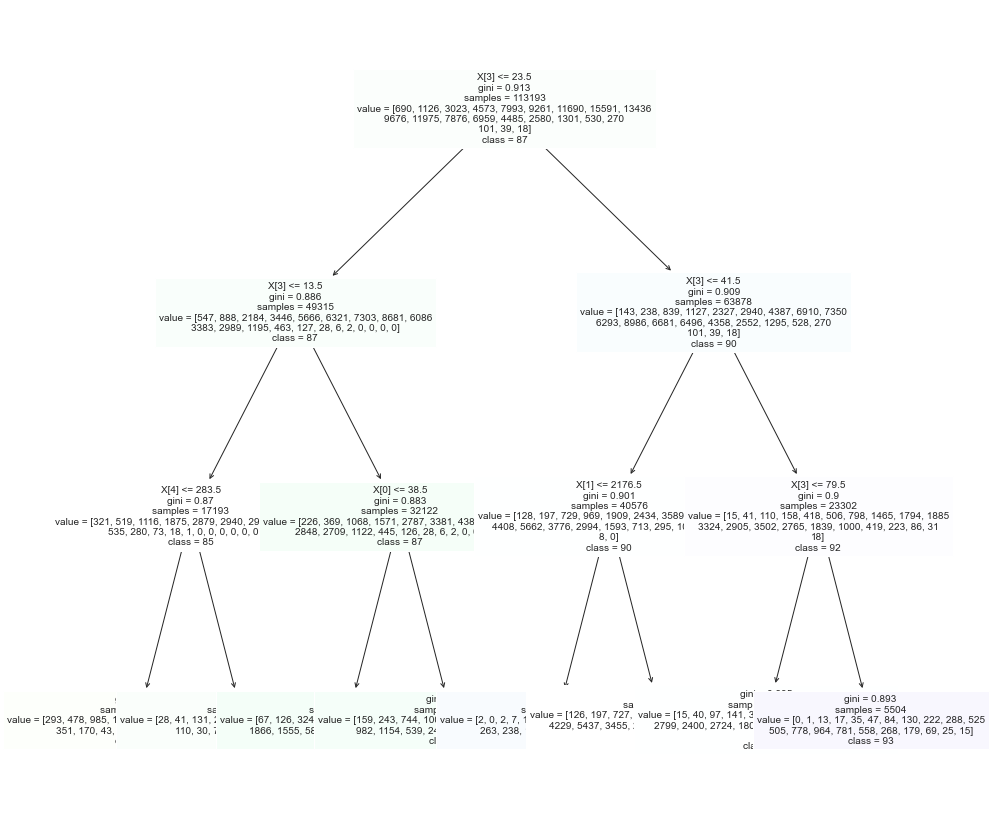

In [46]:
fig, ax = plt.subplots(figsize=(15, 15))
clf = DecisionTreeClassifier(max_depth = 3, 
                             random_state = 0)
clf.fit(X_train, Y_train)
cn=[ '80',  '81',  '82',  '83',  '84',  '85',  '86',  '87',  '88',  '89',  '90',  '91',  '92',
        '93',  '94',  '95',  '96',  '97',  '98',  '99', '100']
plot_tree(clf, fontsize=10, class_names=cn, filled=True)
plt.show()